In [59]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List
import math
import re
from collections import Counter
from plotting_functions import get_curve_idx_from_cluster_color, plot_specific_curves, \
                            plot_pca, plot_clusters_together, plot_clusters_seperately


# Load in all depth vs resistance curves into a dataframe list

In [60]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

In [61]:
data_features_df = pd.read_csv("data/features.csv")
non_clustering_features_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(non_clustering_features_list, axis=1)

# Clustering FeiFei's Labels

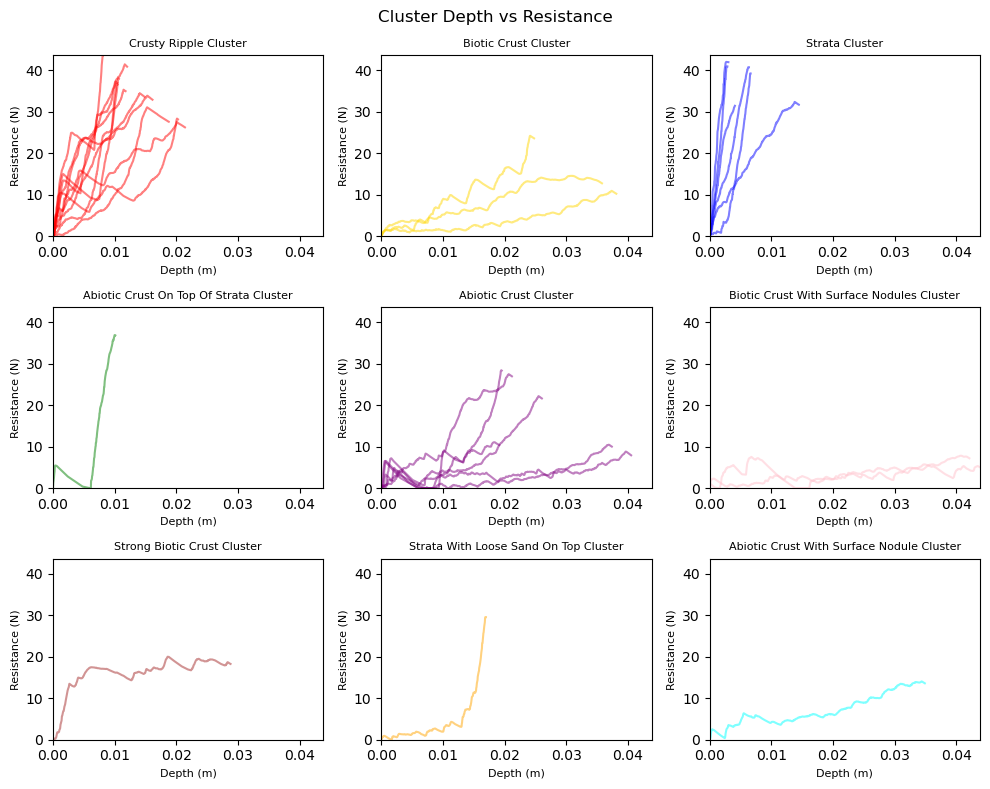

In [63]:
feifeis_features_df = data_features_df[data_features_df['feifeis_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
# encodes object into categorical variables
feifeis_features_df['encoded'], uniques = pd.factorize(feifeis_features_df['feifeis_ylabels'])
y_labels = feifeis_features_df['encoded'].to_list()
# plot_clusters_together(y_labels, feifeis_features_df.index)
plot_clusters_seperately(y_labels, feifeis_features_df.index, depth_resist_curve_df_list, cluster_category_names=uniques.to_list(), filenames=False)

# Clustering Liam's Labels

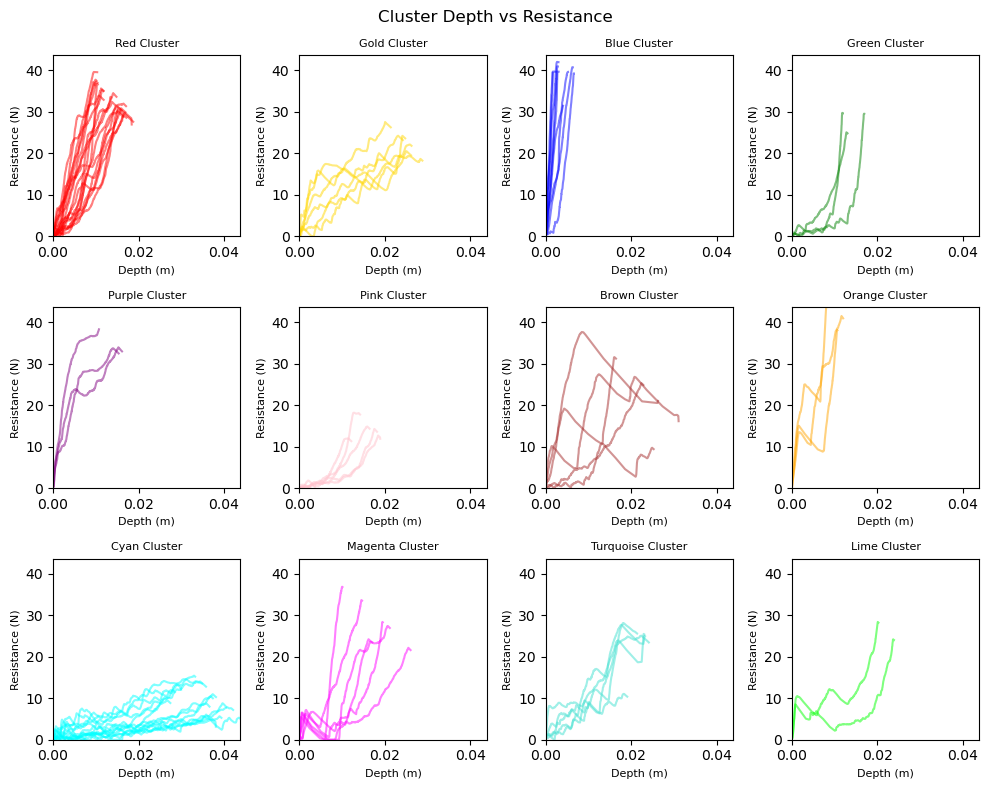

In [64]:
# plot_clusters_together(y_labels=data_features_df['liams_ylabels'])
plot_clusters_seperately(data_features_df['liams_ylabels'], data_features_df.index.tolist(), depth_resist_curve_df_list)

# Clustering Marion's Labels

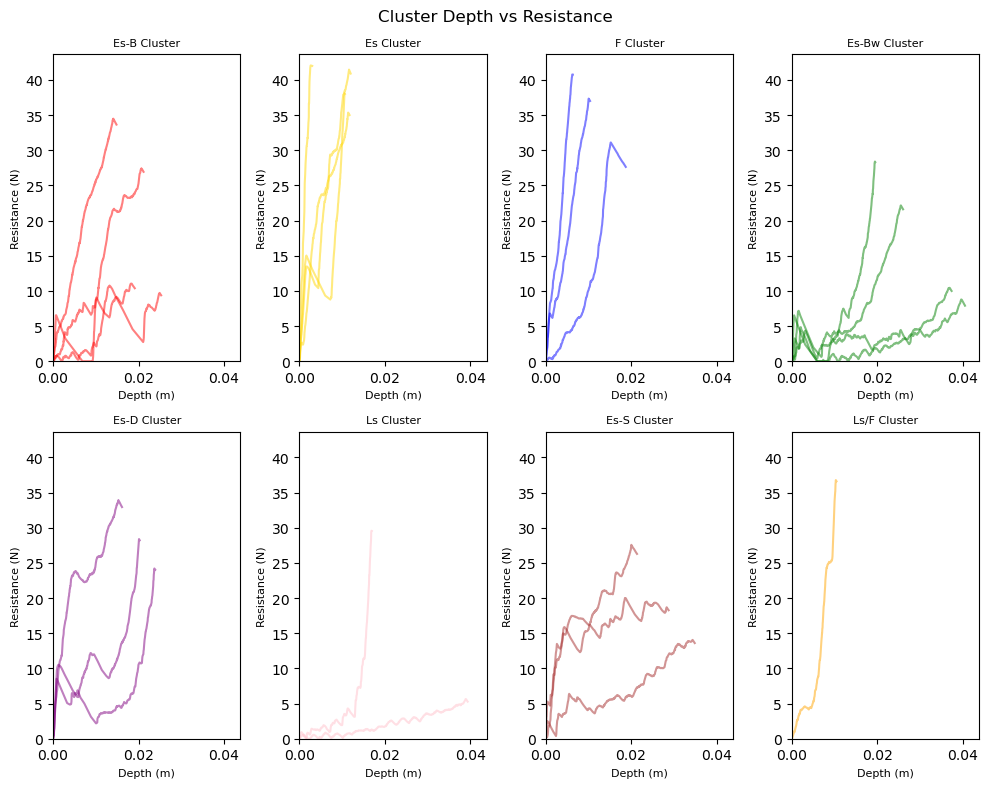

In [65]:
marions_features_df = data_features_df[data_features_df['marions_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
# print(marions_features_df)
# encodes object into categorical variables
marions_features_df['encoded'], uniques = pd.factorize(marions_features_df['marions_ylabels'])
# plot_clusters_together(y_labels=marions_features_df['encoded'])
plot_clusters_seperately(marions_features_df['encoded'].tolist(), marions_features_df.index.tolist(), depth_resist_curve_df_list,
                         cluster_category_names=uniques.tolist())

# Spatial Analysis of Clustering

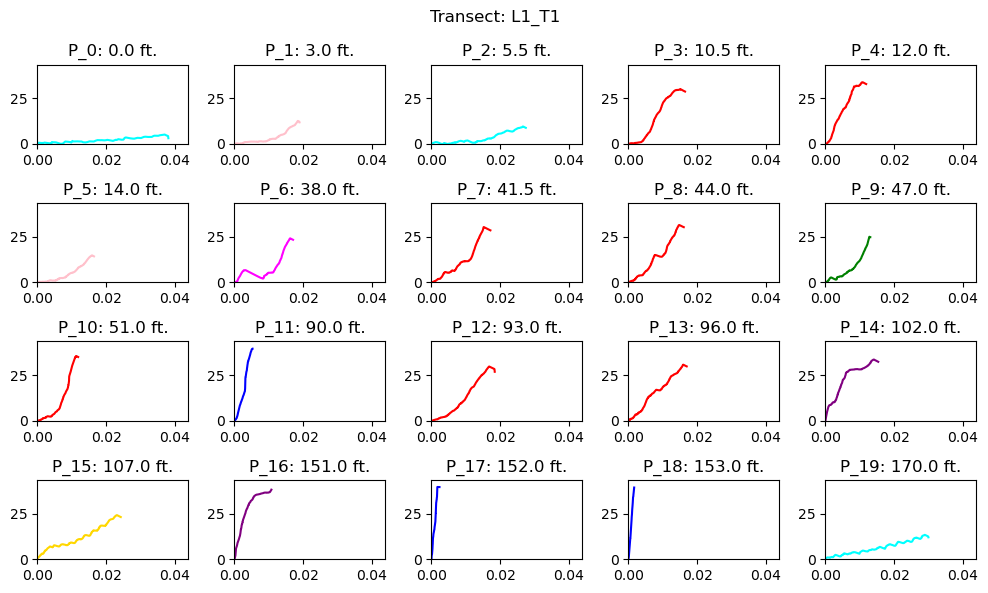

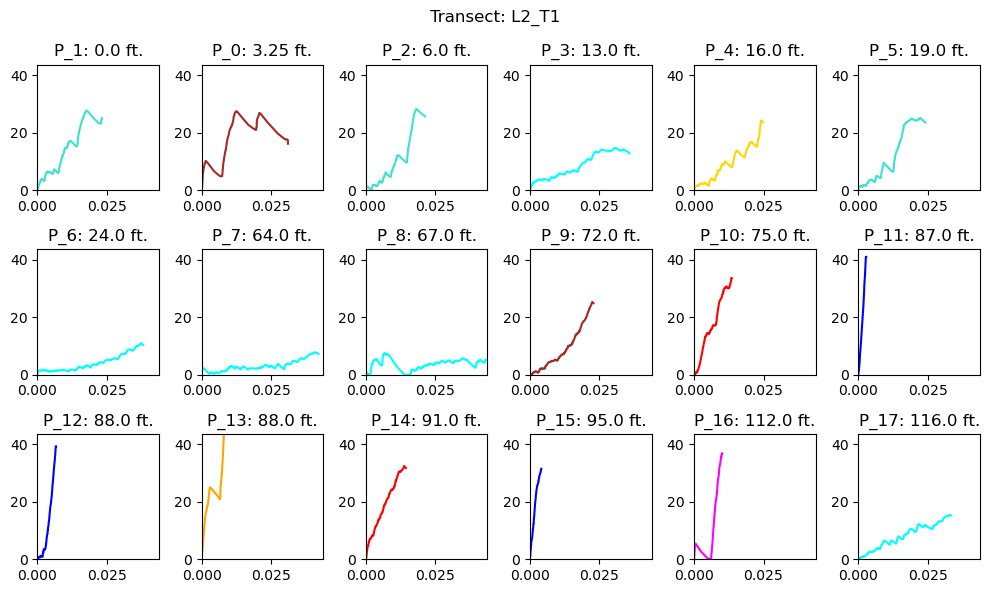

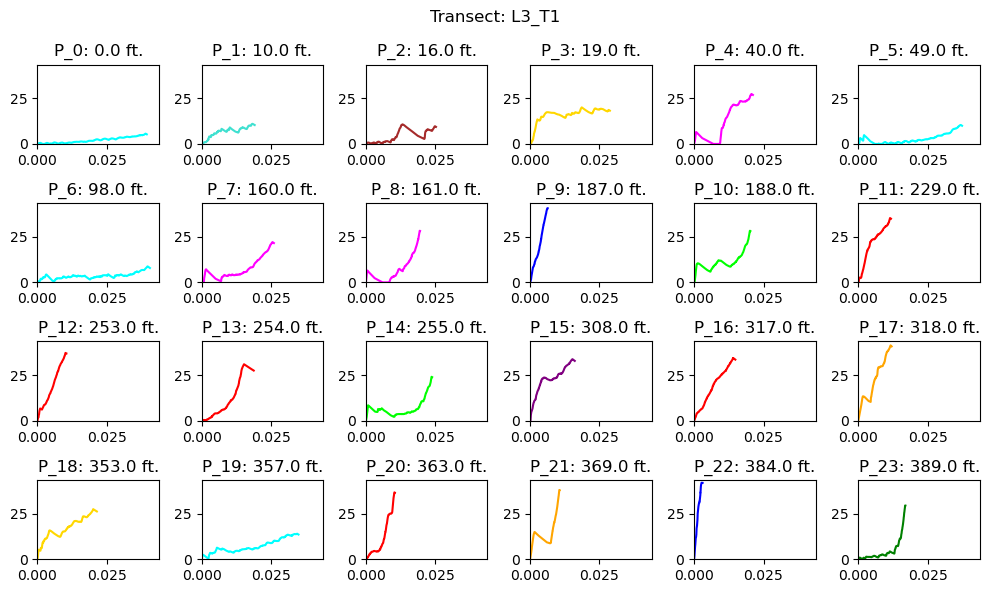

In [66]:
# unique coloring mappings for categories
label_color_map = {0: 'red', 1: 'gold', 2: 'blue', 3: 'green', 4: 'purple', 5: 'pink',
        6: 'brown', 7: 'orange', 8: 'cyan', 9: 'magenta', 10: 'turquoise',
        11: 'lime', 12: 'teal', 13: 'navy', 14: 'maroon', 15: 'olive',
        16: 'coral', 17: 'grey', 18: 'salmon', 19: 'yellow'}

unique_transects = ['L1_T1', 'L2_T1', 'L3_T1']

def group_data_by_transect(unique_transects, data_features_df):
    spatial_features_df = data_features_df[data_features_df['distances'].notna()]
    transect_dict = {}
    for transect in unique_transects:
        transect_dict[transect] = spatial_features_df[spatial_features_df['filenames'].str.contains(transect)]
    # print(transect_dict[transect][['filenames', 'distances']])
    for transect in unique_transects:
        transect_dict[transect] = transect_dict[transect].sort_values(by=['distances'])
    # print(transect_dict[transect][['filenames', 'distances']])
    
    return transect_dict

transect_dict = group_data_by_transect(unique_transects, data_features_df)

def find_plot_dimensions(n):
    for i in range(int(math.sqrt(n)), 0, -1):
        if n % i == 0:
            # prime
            if i == 1 or n % i == 1: return find_plot_dimensions(n+1)
            else: return i, n // i

def plot_transect_subplots(depth_resist_curve_df_list, transect_dict):
    for transect, samples in transect_dict.items():
        masked_indicies = samples.index.tolist()
        # for transect in unique_transects:
        combined_columns = pd.concat(depth_resist_curve_df_list, axis=0, ignore_index=True)
        x, y = find_plot_dimensions(len(samples))
        fig, axs = plt.subplots(x,y,figsize=(10,6))
        fig.suptitle(f"Transect: {transect.title()}")
        for i, ax in enumerate(axs.flatten()):
            ax.set_xlim([0, combined_columns["depth"].max()])
            ax.set_ylim([0, combined_columns["resistance"].max()])
            curve_features = samples.loc[masked_indicies[i]]
            sample_point = re.search(r'P_\d+', curve_features['filenames'])
            ax.set_title(f'{sample_point.group()}: {curve_features['distances']} ft.')
            # ax.set_title(curve_features['filenames'], fontsize=10)
            filename = curve_features['filenames']
            curve = filename_to_depth_resist[filename]
            ax.plot(curve['depth'], curve['resistance'], color=label_color_map[curve_features['liams_ylabels']])
        plt.tight_layout()
        plt.show()

plot_transect_subplots(depth_resist_curve_df_list, transect_dict)